In [1]:
from pathlib import Path
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mne
from mne.preprocessing import ICA
from mne_icalabel import label_components

In [2]:
import torch
print(torch.__version__)
print("MPS available?", torch.backends.mps.is_available())

2.7.1
MPS available? True


### Config — paths & processing constants  

All hard-coded parameters live in one place so you (or a colleague) can
re-run the notebook on another machine by editing a single cell.

* **paths** – BIDS root and sub-folders inside `derivatives/`
* **data**  – recording constants reused later (montage, sfreq, etc.)
* **ica**   – method & hyper-params; change here to compare algorithms
* **reject** – thresholds that tag bad ICs automatically
* **features** – what spectral bands & window length to extract
* **model** – a first classifier + CV split; purely exploratory


In [40]:
CONFIG = dict(

    # ---------- paths ----------------------------------------------------
    paths = dict(
        bids_root   = Path("../bids_dataset"),
        deriv_root  = Path("../bids_dataset/derivatives"),
        filt_dir    = Path("../bids_dataset/derivatives/filt_crop"),
        ica_dir     = Path("../bids_dataset/derivatives/ica_clean"),
        feat_dir    = Path("../bids_dataset/derivatives/features"),
        annot_dir   = Path("../bids_dataset/derivatives/annotated"),
        timing_csv  = Path("../audio-timeline.csv"),
    ),

    # ---------- recording constants --------------------------------------
    data = dict(
        sfreq       = 125.0,                      # Hz
        eeg_ch      = ["Fp1","Fp2","C3","C4","T7","T8",
                       "O1","O2","F3","F4","Fz","Pz","P3","P4"],
        montage     = "standard_1020",
        n_blocks    = 20,
    ),

    # ---------- ICA parameters -------------------------------------------
    ica = dict(
        method         = "picard",    # "fastica" | "picard" | "infomax"
        n_components   = 0.99,        # keep 99 % of variance
        random_state   = 42,
        max_iter       = 500,
        decim          = 2            # 125 Hz → 62.5 Hz for fitting
    ),

    # ---------- auto-reject thresholds (z-score in IC space) -------------
    reject = dict(
        eog_z     = 3.0,     # eye blinks
        emg_z     = 3.0,     # muscle
        slow_z    = 3.0      # slow drifts
    ),

    # ---------- feature extraction ---------------------------------------
    features = dict(
        bands   = {"delta":(1,4), "theta":(4,8),
                   "alpha":(8,13), "beta":(13,30),
                   "gamma":(30,45)},
        win_sec       = 2.0,   # sliding-window length
        step_sec      = 0.5,
        wavelet_levels = 6
    ),

    # ---------- first classifier to prototype ----------------------------
    model = dict(
        clf          = "lightgbm",   # or "svm"
        cv_folds     = 5,
        test_size    = 0.2
    ),
)

# ------------------------------------------------------------------------
# create sub-folders if they don’t exist
for p in CONFIG["paths"].values():
    if p.suffix == "":          # skip the CSV path; only create dirs
        p.mkdir(parents=True, exist_ok=True)

print("Config updated – paths for annotations and timeline CSV added 🚀")

Config updated – paths for annotations and timeline CSV added 🚀


## 1. Loading the 20 filtered & cropped blocks

Before any additional processing we first bring the twenty pre-filtered /
cropped recordings into memory.  
At this stage **projectors remain OFF** so the data are identical to the files
written by 04_Lina_restart_with_MNE (`*_flt-crop_raw.fif`).


In [4]:
# Gather the expected *.fif files
blk_paths = sorted(
    CONFIG["paths"]["filt_dir"].glob("blk??_flt-crop_raw.fif")
)
assert len(blk_paths) == CONFIG["data"]["n_blocks"], (
    f"Expected {CONFIG['data']['n_blocks']} blocks, found {len(blk_paths)}."
)

raw_blocks = []
for fpath in blk_paths:
    print(f"Reading {fpath.name} …", end=" ")
    raw = mne.io.read_raw_fif(fpath, preload=True, verbose=False)
    raw_blocks.append(raw)
    print("✓")

print(f"\nLoaded {len(raw_blocks)} blocks. Projectors are currently OFF.")

Reading blk00_flt-crop_raw.fif … ✓
Reading blk01_flt-crop_raw.fif … ✓
Reading blk02_flt-crop_raw.fif … ✓
Reading blk03_flt-crop_raw.fif … ✓
Reading blk04_flt-crop_raw.fif … ✓
Reading blk05_flt-crop_raw.fif … ✓
Reading blk06_flt-crop_raw.fif … ✓
Reading blk07_flt-crop_raw.fif … ✓
Reading blk08_flt-crop_raw.fif … ✓
Reading blk09_flt-crop_raw.fif … ✓
Reading blk10_flt-crop_raw.fif … ✓
Reading blk11_flt-crop_raw.fif … ✓
Reading blk12_flt-crop_raw.fif … ✓
Reading blk13_flt-crop_raw.fif … ✓
Reading blk14_flt-crop_raw.fif … ✓
Reading blk15_flt-crop_raw.fif … ✓
Reading blk16_flt-crop_raw.fif … ✓
Reading blk17_flt-crop_raw.fif … ✓
Reading blk18_flt-crop_raw.fif … ✓
Reading blk19_flt-crop_raw.fif … ✓

Loaded 20 blocks. Projectors are currently OFF.


### 1a · Why we switch **ON** the average-reference projection

Each `.fif` block already contains a *projector* that re-references the data to
the **common average** (CAR).  Up to this point we kept that projector **OFF**
to ensure the raw voltages from the previous notebook were preserved during
filtering/cropping.  Turning the projector **ON** now is critical for three
reasons:

1. **Signal centring**   
   Referencing every channel to the grand mean neutralises slow offsets caused
   by unequal electrode impedances or amplifier drift.  This flattens the
   baseline and yields cleaner butterfly plots and topomaps.

2. **Better ICA decomposition**   
   ICA assumes that sources mix *linearly* and with zero-mean time courses.
   Applying the CAR before decomposition improves the separation of ocular,
   cardiac and myogenic components, making automatic IC labelling more
   reliable.

3. **Pipeline consistency**   
   Most EEG-to-text decoding papers perform ICA on average-referenced data.
   Activating the projector now keeps our workflow aligned with that
   literature and prevents accidental mixing of referenced and
   non-referenced epochs later on.

> **Note:** `raw.apply_proj()` is *idempotent*—once the projector is applied,
> calling it again will have no additional effect as the projection matrix is
> removed from `raw.info["projs"]`.


In [5]:
for idx, raw in enumerate(raw_blocks):
    if not raw.info["projs"]:
        raise RuntimeError(f"Block {idx:02d} has no projector defined.")
    raw.apply_proj(verbose=False)

print(f"✅  Average-reference projection applied to {len(raw_blocks)} blocks.")

✅  Average-reference projection applied to 20 blocks.


#### Where does the stored **common-average reference (CAR)** come from?

The projector you see inside each `Raw` file was created in the previous notebook (the
pre-processing stage) with the following single line of MNE-Python:

```python
raw.set_eeg_reference("average", projection=True)
````

**Why defer application?**

Filtering, notch removal, and cropping were performed on the original voltage
scale to avoid numerical artefacts that can arise when the reference itself is
filtered. By postponing the CAR we ensure it touches the already-cleaned
signal only once, making the operation idempotent.

So, the CAR originates entirely from this offline MNE call—nothing was changed
on the OpenBCI Cyton hardware during acquisition. The headset’s built-in bias
drive delivered a common electrode reference while recording; the average
reference we apply now is purely a software construct saved inside each
.fif file.

## 2. ICA cleaning with Picard and automatic component rejection

With all blocks now average-referenced, the next step is to remove ocular,
muscular, cardiac, and line-noise artefacts via **Independent Component
Analysis (ICA)**.  We adopt the following design:

| Choice | Value | Rationale |
|--------|-------|-----------|
| *Algorithm* | **Picard** (`method="picard"`) | Fast and deterministic when seeded, converges reliably on small channel counts. |
| *Number of components* | `n_components = 0.99` | Keep enough PCs to explain ≥ 99 % variance while discarding tiny noise dimensions. |
| *Sample thinning* | `decim = 2` (training at ~62.5 Hz) | Avoids aliasing of our 1–45 Hz pass-band and gives ~2× speed-up over full-rate fitting. |
| *Auto-labelling* | `mne_icalabel` if available; fallback to `find_bads_eog/muscle` with z-scores in `CONFIG["reject"]` | Fully reproducible; manual tweaks can follow in the QA report. |
| *Output files* | Cleaned `Raw`  → `ica_clean/blk##_icaclean_raw.fif`<br>ICA object → `ica_clean/blk##_ica.fif` | Keeps both the processed data and the unmixing matrix for later inspection. |

The cleaned signals will still be stored at the **original 125 Hz**, because
the unmixing matrix learned on the thinned data is applied to the full-rate
recordings.


In [6]:
for raw in raw_blocks:
    assert raw.proj     , "CAR not applied?"
    assert raw.info['sfreq'] == 125.0, "Unexpected sampling rate!"

print("✅  Sanity check passed for all blocks.")

✅  Sanity check passed for all blocks.


### Why we fit **one ICA per block** instead of concatenating all 20 blocks

| Argument | Details |
|-----------|---------|
| **1 — Temporal stationarity** | ICA assumes that sources and their mixing matrix stay *constant* during the data used for fitting.  Each block is only ≈ 133 s; across 47 min the participant’s posture, electrode impedance, or low-level muscle tone can drift, breaking the stationarity assumption.  By fitting block-wise we give Picard data that better meet its mathematical requirements. |
| **2 — Transient artefacts** | Some artefacts (e.g. a coughing bout, jaw clench) may appear in just one or two blocks.  Concatenating would spread those components’ influence across the global unmixing matrix, making them harder to isolate or causing “ghost” ICs in clean segments.  Per-block fitting localises the fix to where the artefact actually occurs. |
| **3 — Memory & speed** | 47 min × 14 ch × 125 Hz ≈ 490 000 samples.  Even with `decim=2`, a single global ICA would hold > 200 kB of data in memory during optimisation and take several times longer to converge.  Twenty small ICAs (7–9 comps each) finish in a few seconds per block and can be parallelised if desired. |
| **4 — Easier re-processing** | If a block later shows unexpected noise, we can re-fit ICA *only for that block* without touching the other 19 clean ones.  This keeps the pipeline modular and speeds up iterations. |
| **5 — Simplicity for downstream QA** | Each `blk##_ica.fif` carries its own component labels.  The QA report can display “before/after” figures alongside the block’s lyrics slice, making inspection intuitive. |


> *Trade-off:* concatenating could, in theory, yield slightly better separation of **persistent** artefacts (e.g. ECG) by giving ICA more samples.  In practice the benefits rarely outweigh the non-stationarity risk for long, naturalistic EEG sessions like ours.



### Block blk00: fitting ICA …


/var/folders/ny/tk1xvwsn7n11pkl0vlgl1sz80000gn/T/ipykernel_3102/4120489333.py:22: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  out    = label_components(raw, ica, method="iclabel")
/var/folders/ny/tk1xvwsn7n11pkl0vlgl1sz80000gn/T/ipykernel_3102/4120489333.py:22: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  out    = label_components(raw, ica, method="iclabel")


    ICLabel → excluding [1] (prob ≥ 0.8)


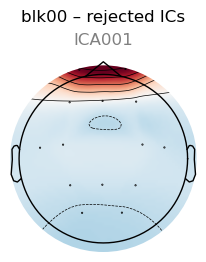

Applying ICA to Raw instance
    Applying projection operator with 1 vector (pre-whitener application)
    Transforming to ICA space (7 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components

### Block blk01: fitting ICA …


/var/folders/ny/tk1xvwsn7n11pkl0vlgl1sz80000gn/T/ipykernel_3102/4120489333.py:22: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  out    = label_components(raw, ica, method="iclabel")
/var/folders/ny/tk1xvwsn7n11pkl0vlgl1sz80000gn/T/ipykernel_3102/4120489333.py:22: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  out    = label_components(raw, ica, method="iclabel")


    ICLabel → excluding [1] (prob ≥ 0.8)


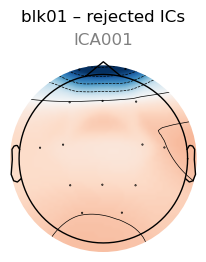

Applying ICA to Raw instance
    Applying projection operator with 1 vector (pre-whitener application)
    Transforming to ICA space (7 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components

### Block blk02: fitting ICA …


/var/folders/ny/tk1xvwsn7n11pkl0vlgl1sz80000gn/T/ipykernel_3102/4120489333.py:22: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  out    = label_components(raw, ica, method="iclabel")
/var/folders/ny/tk1xvwsn7n11pkl0vlgl1sz80000gn/T/ipykernel_3102/4120489333.py:22: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  out    = label_components(raw, ica, method="iclabel")


    ICLabel → excluding [1] (prob ≥ 0.8)


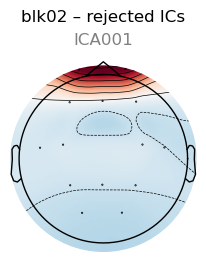

Applying ICA to Raw instance
    Applying projection operator with 1 vector (pre-whitener application)
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components

### Block blk03: fitting ICA …


/var/folders/ny/tk1xvwsn7n11pkl0vlgl1sz80000gn/T/ipykernel_3102/4120489333.py:22: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  out    = label_components(raw, ica, method="iclabel")
/var/folders/ny/tk1xvwsn7n11pkl0vlgl1sz80000gn/T/ipykernel_3102/4120489333.py:22: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  out    = label_components(raw, ica, method="iclabel")


    ICLabel → excluding [1, 5] (prob ≥ 0.8)


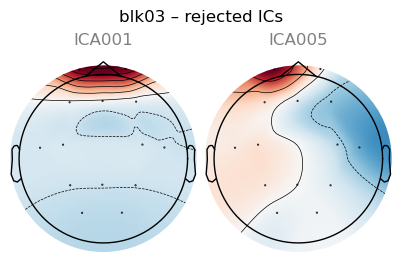

Applying ICA to Raw instance
    Applying projection operator with 1 vector (pre-whitener application)
    Transforming to ICA space (8 components)
    Zeroing out 2 ICA components
    Projecting back using 14 PCA components

### Block blk04: fitting ICA …


/var/folders/ny/tk1xvwsn7n11pkl0vlgl1sz80000gn/T/ipykernel_3102/4120489333.py:22: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  out    = label_components(raw, ica, method="iclabel")
/var/folders/ny/tk1xvwsn7n11pkl0vlgl1sz80000gn/T/ipykernel_3102/4120489333.py:22: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  out    = label_components(raw, ica, method="iclabel")


    ICLabel → excluding [1] (prob ≥ 0.8)


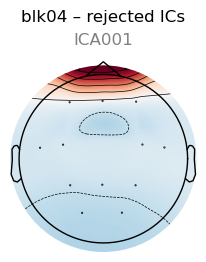

Applying ICA to Raw instance
    Applying projection operator with 1 vector (pre-whitener application)
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components

### Block blk05: fitting ICA …


/var/folders/ny/tk1xvwsn7n11pkl0vlgl1sz80000gn/T/ipykernel_3102/4120489333.py:22: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  out    = label_components(raw, ica, method="iclabel")
/var/folders/ny/tk1xvwsn7n11pkl0vlgl1sz80000gn/T/ipykernel_3102/4120489333.py:22: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  out    = label_components(raw, ica, method="iclabel")


    ICLabel → excluding [0] (prob ≥ 0.8)


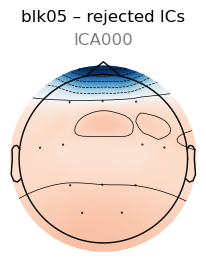

Applying ICA to Raw instance
    Applying projection operator with 1 vector (pre-whitener application)
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components

### Block blk06: fitting ICA …


/var/folders/ny/tk1xvwsn7n11pkl0vlgl1sz80000gn/T/ipykernel_3102/4120489333.py:22: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  out    = label_components(raw, ica, method="iclabel")
/var/folders/ny/tk1xvwsn7n11pkl0vlgl1sz80000gn/T/ipykernel_3102/4120489333.py:22: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  out    = label_components(raw, ica, method="iclabel")


    ICLabel → excluding [0] (prob ≥ 0.8)


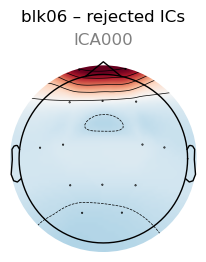

Applying ICA to Raw instance
    Applying projection operator with 1 vector (pre-whitener application)
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components

### Block blk07: fitting ICA …


/var/folders/ny/tk1xvwsn7n11pkl0vlgl1sz80000gn/T/ipykernel_3102/4120489333.py:22: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  out    = label_components(raw, ica, method="iclabel")
/var/folders/ny/tk1xvwsn7n11pkl0vlgl1sz80000gn/T/ipykernel_3102/4120489333.py:22: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  out    = label_components(raw, ica, method="iclabel")


    ICLabel → excluding [0] (prob ≥ 0.8)


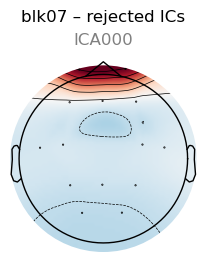

Applying ICA to Raw instance
    Applying projection operator with 1 vector (pre-whitener application)
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components

### Block blk08: fitting ICA …


/var/folders/ny/tk1xvwsn7n11pkl0vlgl1sz80000gn/T/ipykernel_3102/4120489333.py:22: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  out    = label_components(raw, ica, method="iclabel")
/var/folders/ny/tk1xvwsn7n11pkl0vlgl1sz80000gn/T/ipykernel_3102/4120489333.py:22: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  out    = label_components(raw, ica, method="iclabel")


    ICLabel → excluding [0] (prob ≥ 0.8)


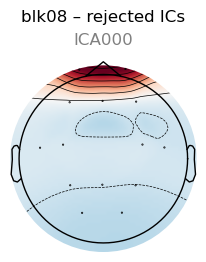

Applying ICA to Raw instance
    Applying projection operator with 1 vector (pre-whitener application)
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components

### Block blk09: fitting ICA …


/var/folders/ny/tk1xvwsn7n11pkl0vlgl1sz80000gn/T/ipykernel_3102/4120489333.py:22: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  out    = label_components(raw, ica, method="iclabel")
/var/folders/ny/tk1xvwsn7n11pkl0vlgl1sz80000gn/T/ipykernel_3102/4120489333.py:22: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  out    = label_components(raw, ica, method="iclabel")


    ICLabel → excluding [0] (prob ≥ 0.8)


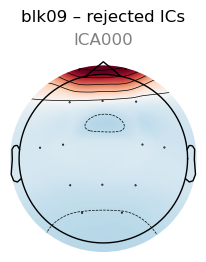

Applying ICA to Raw instance
    Applying projection operator with 1 vector (pre-whitener application)
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components

### Block blk10: fitting ICA …


/var/folders/ny/tk1xvwsn7n11pkl0vlgl1sz80000gn/T/ipykernel_3102/4120489333.py:22: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  out    = label_components(raw, ica, method="iclabel")
/var/folders/ny/tk1xvwsn7n11pkl0vlgl1sz80000gn/T/ipykernel_3102/4120489333.py:22: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  out    = label_components(raw, ica, method="iclabel")


    ICLabel → excluding [0] (prob ≥ 0.8)


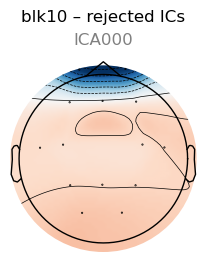

Applying ICA to Raw instance
    Applying projection operator with 1 vector (pre-whitener application)
    Transforming to ICA space (9 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components

### Block blk11: fitting ICA …


/var/folders/ny/tk1xvwsn7n11pkl0vlgl1sz80000gn/T/ipykernel_3102/4120489333.py:22: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  out    = label_components(raw, ica, method="iclabel")
/var/folders/ny/tk1xvwsn7n11pkl0vlgl1sz80000gn/T/ipykernel_3102/4120489333.py:22: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  out    = label_components(raw, ica, method="iclabel")


    ICLabel → excluding [0] (prob ≥ 0.8)


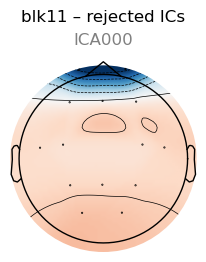

Applying ICA to Raw instance
    Applying projection operator with 1 vector (pre-whitener application)
    Transforming to ICA space (9 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components

### Block blk12: fitting ICA …


/var/folders/ny/tk1xvwsn7n11pkl0vlgl1sz80000gn/T/ipykernel_3102/4120489333.py:22: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  out    = label_components(raw, ica, method="iclabel")
/var/folders/ny/tk1xvwsn7n11pkl0vlgl1sz80000gn/T/ipykernel_3102/4120489333.py:22: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  out    = label_components(raw, ica, method="iclabel")


    ICLabel → excluding [0] (prob ≥ 0.8)


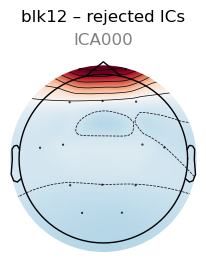

Applying ICA to Raw instance
    Applying projection operator with 1 vector (pre-whitener application)
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components

### Block blk13: fitting ICA …


/var/folders/ny/tk1xvwsn7n11pkl0vlgl1sz80000gn/T/ipykernel_3102/4120489333.py:22: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  out    = label_components(raw, ica, method="iclabel")
/var/folders/ny/tk1xvwsn7n11pkl0vlgl1sz80000gn/T/ipykernel_3102/4120489333.py:22: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  out    = label_components(raw, ica, method="iclabel")


    ICLabel → excluding [0] (prob ≥ 0.8)


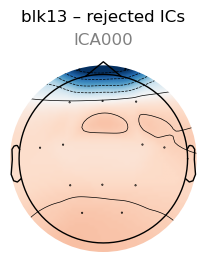

Applying ICA to Raw instance
    Applying projection operator with 1 vector (pre-whitener application)
    Transforming to ICA space (9 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components

### Block blk14: fitting ICA …


/var/folders/ny/tk1xvwsn7n11pkl0vlgl1sz80000gn/T/ipykernel_3102/4120489333.py:22: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  out    = label_components(raw, ica, method="iclabel")
/var/folders/ny/tk1xvwsn7n11pkl0vlgl1sz80000gn/T/ipykernel_3102/4120489333.py:22: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  out    = label_components(raw, ica, method="iclabel")


    ICLabel → excluding [0, 5] (prob ≥ 0.8)


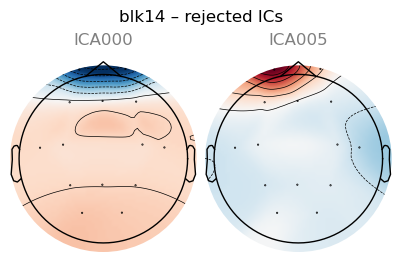

Applying ICA to Raw instance
    Applying projection operator with 1 vector (pre-whitener application)
    Transforming to ICA space (9 components)
    Zeroing out 2 ICA components
    Projecting back using 14 PCA components

### Block blk15: fitting ICA …


/var/folders/ny/tk1xvwsn7n11pkl0vlgl1sz80000gn/T/ipykernel_3102/4120489333.py:22: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  out    = label_components(raw, ica, method="iclabel")
/var/folders/ny/tk1xvwsn7n11pkl0vlgl1sz80000gn/T/ipykernel_3102/4120489333.py:22: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  out    = label_components(raw, ica, method="iclabel")


    ICLabel → excluding [0] (prob ≥ 0.8)


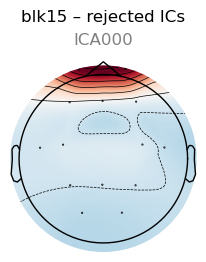

Applying ICA to Raw instance
    Applying projection operator with 1 vector (pre-whitener application)
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components

### Block blk16: fitting ICA …


/var/folders/ny/tk1xvwsn7n11pkl0vlgl1sz80000gn/T/ipykernel_3102/4120489333.py:22: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  out    = label_components(raw, ica, method="iclabel")
/var/folders/ny/tk1xvwsn7n11pkl0vlgl1sz80000gn/T/ipykernel_3102/4120489333.py:22: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  out    = label_components(raw, ica, method="iclabel")


    ICLabel → excluding [0] (prob ≥ 0.8)


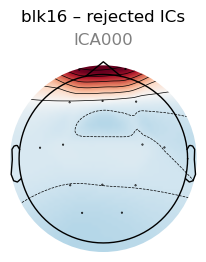

Applying ICA to Raw instance
    Applying projection operator with 1 vector (pre-whitener application)
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components

### Block blk17: fitting ICA …


/var/folders/ny/tk1xvwsn7n11pkl0vlgl1sz80000gn/T/ipykernel_3102/4120489333.py:22: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  out    = label_components(raw, ica, method="iclabel")
/var/folders/ny/tk1xvwsn7n11pkl0vlgl1sz80000gn/T/ipykernel_3102/4120489333.py:22: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  out    = label_components(raw, ica, method="iclabel")


    ICLabel → excluding [0] (prob ≥ 0.8)


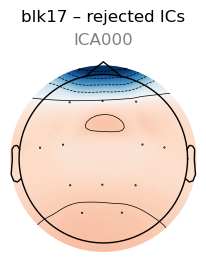

Applying ICA to Raw instance
    Applying projection operator with 1 vector (pre-whitener application)
    Transforming to ICA space (9 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components

### Block blk18: fitting ICA …


/var/folders/ny/tk1xvwsn7n11pkl0vlgl1sz80000gn/T/ipykernel_3102/4120489333.py:22: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  out    = label_components(raw, ica, method="iclabel")
/var/folders/ny/tk1xvwsn7n11pkl0vlgl1sz80000gn/T/ipykernel_3102/4120489333.py:22: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  out    = label_components(raw, ica, method="iclabel")


    ICLabel → excluding [0] (prob ≥ 0.8)


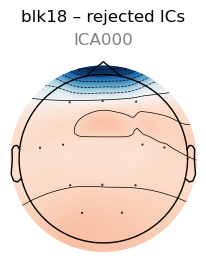

Applying ICA to Raw instance
    Applying projection operator with 1 vector (pre-whitener application)
    Transforming to ICA space (9 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components

### Block blk19: fitting ICA …


/var/folders/ny/tk1xvwsn7n11pkl0vlgl1sz80000gn/T/ipykernel_3102/4120489333.py:22: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  out    = label_components(raw, ica, method="iclabel")
/var/folders/ny/tk1xvwsn7n11pkl0vlgl1sz80000gn/T/ipykernel_3102/4120489333.py:22: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  out    = label_components(raw, ica, method="iclabel")


    ICLabel → excluding [1] (prob ≥ 0.8)


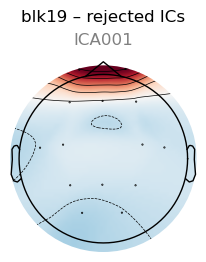

Applying ICA to Raw instance
    Applying projection operator with 1 vector (pre-whitener application)
    Transforming to ICA space (9 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components

🎉  Re-run complete – artefact ICs agora realmente excluídos.


In [34]:
ica_dir = CONFIG["paths"]["ica_dir"]
THRESH  = 0.80
KEYWORDS = ("eye", "muscle", "heart", "line")   # artefact classes

for raw, in_path in zip(
        raw_blocks,
        sorted(CONFIG["paths"]["filt_dir"].glob("blk??_flt-crop_raw.fif"))):

    stem = Path(in_path).stem.replace("_flt-crop_raw", "")
    print(f"\n### Block {stem}: fitting ICA …")

    ica = mne.preprocessing.ICA(
        n_components=CONFIG["ica"]["n_components"],
        method=CONFIG["ica"]["method"],
        random_state=CONFIG["ica"]["random_state"],
        max_iter=CONFIG["ica"]["max_iter"],
        fit_params=dict(ortho=False, extended=True),
    )
    ica.fit(raw, decim=CONFIG["ica"]["decim"], verbose="error")

    # ---------- ICLabel ---------------------------------------------------
    out    = label_components(raw, ica, method="iclabel")
    labels = out["labels"]            # list[str]
    proba  = np.asanyarray(out["y_pred_proba"])   # 1-D ou 2-D → ndarray

    exclude_idx = []
    for i, lab in enumerate(labels):
        p = proba[i] if proba.ndim == 1 else proba[i].max()
        if any(kw in lab.lower() for kw in KEYWORDS) and p >= THRESH:
            exclude_idx.append(i)

    print(f"    ICLabel → excluding {exclude_idx} (prob ≥ {THRESH})")
    ica.exclude = exclude_idx

    if exclude_idx:          # visual feedback opcional
        ica.plot_components(picks=exclude_idx,
                            title=f"{stem} – rejected ICs", show=True)

    ica.apply(raw)

    raw.save(ica_dir / f"{stem}_icaclean_raw.fif", overwrite=True, verbose=False)
    ica.save(ica_dir / f"{stem}_ica.fif",           overwrite=True, verbose=False)

print("\n🎉  Re-run complete – artefact ICs agora realmente excluídos.")


In [35]:
blk_idx = 18                      # <-- pick a block
stem    = f"blk{blk_idx:02d}"

raw_path = CONFIG["paths"]["filt_dir"] / f"{stem}_flt-crop_raw.fif"
raw      = mne.io.read_raw_fif(raw_path, preload=True)

ica_path = CONFIG["paths"]["ica_dir"] / f"{stem}_ica.fif"
ica      = mne.preprocessing.read_ica(ica_path)

out      = label_components(raw, ica, method="iclabel")
labels, proba = out["labels"], out["y_pred_proba"]

tbl = [f"IC {i:02d}  {labels[i]:<10}  p={proba[i].max():.2f}"
       for i in range(len(labels))]
pp.pprint(tbl)


Opening raw data file ../bids_dataset/derivatives/filt_crop/blk18_flt-crop_raw.fif...
    Read a total of 1 projection items:
        Average EEG reference (1 x 14)  idle
    Range : 875 ... 17538 =      7.000 ...   140.304 secs
Ready.
Reading 0 ... 16663  =      0.000 ...   133.304 secs...
Reading /Users/linalopes/Desktop/creativity-in-vitro-eeg/notebooks/../bids_dataset/derivatives/ica_clean/blk18_ica.fif ...
    Read a total of 1 projection items:
        Average EEG reference (1 x 14) active
Now restoring ICA solution ...
Ready.


/var/folders/ny/tk1xvwsn7n11pkl0vlgl1sz80000gn/T/ipykernel_3102/1149565471.py:10: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  out      = label_components(raw, ica, method="iclabel")
/var/folders/ny/tk1xvwsn7n11pkl0vlgl1sz80000gn/T/ipykernel_3102/1149565471.py:10: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  out      = label_components(raw, ica, method="iclabel")


['IC 00  eye blink   p=0.88',
 'IC 01  brain       p=0.52',
 'IC 02  brain       p=1.00',
 'IC 03  brain       p=1.00',
 'IC 04  brain       p=0.63',
 'IC 05  brain       p=0.66',
 'IC 06  brain       p=0.86',
 'IC 07  channel noise  p=0.54',
 'IC 08  eye blink   p=0.57']


## 3. Inspection of ICA results (example: blk18)

Below we reload both the fitted **ICA model** and the corresponding
**cleaned Raw** for *blk18* (the penultimate block) and:

1. Print a textual summary of which ICs were excluded and their labels.  
2. Display the topomaps of the rejected components and the “before vs after”
   butterfly plot so we can verify that eye / muscle artefacts are gone.


In [36]:
blk_idx = 18                                 # penultimate block (0-based)
stem = f"blk{blk_idx:02d}"
ica_path  = CONFIG["paths"]["ica_dir"] / f"{stem}_ica.fif"
raw_path  = CONFIG["paths"]["ica_dir"] / f"{stem}_icaclean_raw.fif"

ica  = mne.preprocessing.read_ica(ica_path)
raw  = mne.io.read_raw_fif(raw_path, preload=True)  # just to know ch-names

print(f"=== {stem}  ICA summary ===")
print("Excluded IC indices :", ica.exclude)
try:
    print("ICLabel classes   :", ica.labels_)  # added by label_components
except AttributeError:
    print("No 'labels_' attr → ICLabel not run / not saved.")

print(f"Cleaned Raw shape  : {raw._data.shape}  (n_ch × n_samples)")


Reading /Users/linalopes/Desktop/creativity-in-vitro-eeg/notebooks/../bids_dataset/derivatives/ica_clean/blk18_ica.fif ...
    Read a total of 1 projection items:
        Average EEG reference (1 x 14) active
Now restoring ICA solution ...
Ready.
Opening raw data file ../bids_dataset/derivatives/ica_clean/blk18_icaclean_raw.fif...
    Read a total of 1 projection items:
        Average EEG reference (1 x 14) active
    Range : 875 ... 17538 =      7.000 ...   140.304 secs
Ready.
Reading 0 ... 16663  =      0.000 ...   133.304 secs...
=== blk18  ICA summary ===
Excluded IC indices : [np.int32(0)]
ICLabel classes   : {'brain': [1, 2, 3, 4, 5, 6], 'muscle': [], 'eog': [0, 8], 'ecg': [], 'line_noise': [], 'ch_noise': [7], 'other': []}
Cleaned Raw shape  : (15, 16664)  (n_ch × n_samples)


In [26]:
# peak-to-peak (µV) for each EEG channel
data_uV = raw_orig.get_data(picks="eeg") * 1e6        # V → µV
pp      = np.ptp(data_uV, axis=1)                     # <- use np.ptp()
median_pp = np.median(pp)

print(f"Median peak-to-peak: {median_pp:.2f} µV")

scale_val = (median_pp / 2) * 1e-6    # back to volts per division
scale = dict(eeg=scale_val)


Median peak-to-peak: 2.40 µV


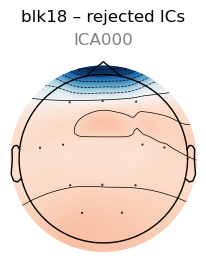

Opening raw data file ../bids_dataset/derivatives/filt_crop/blk18_flt-crop_raw.fif...
    Read a total of 1 projection items:
        Average EEG reference (1 x 14)  idle
    Range : 875 ... 17538 =      7.000 ...   140.304 secs
Ready.
Reading 0 ... 16663  =      0.000 ...   133.304 secs...
Using pyopengl with version 3.1.9
Applying ICA to Raw instance
    Applying projection operator with 1 vector (pre-whitener application)
    Transforming to ICA space (9 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
Using pyopengl with version 3.1.9


In [37]:
# Visual sanity checks for blk18

# --- Topomaps of rejected ICs -------------------------------------------
if ica.exclude:
    ica.plot_components(picks=ica.exclude, title=f"{stem} – rejected ICs",
                        show=True)

# --- Butterfly before vs after ------------------------------------------
# Load the original filtered/cropped (but *not* ICA-cleaned) data
orig_path = CONFIG["paths"]["filt_dir"] / f"{stem}_flt-crop_raw.fif"
raw_orig  = mne.io.read_raw_fif(orig_path, preload=True)

fig1 = raw_orig.plot(title=f"{stem} – BEFORE ICA  (custom scale)",
                     scalings=scale, show=True)

fig2 = ica.apply(raw_orig.copy(), exclude=ica.exclude)\
          .plot(title=f"{stem} – AFTER ICA  (custom scale)",
                scalings=scale, show=True)

plt.show()


## 4. Injecting phrase targets as MNE Annotations

**Why here?**  
We already removed the blink columns and cleaned artefacts, so the next
immutable step is to stamp every `Raw` object with the six lyrical phrases
(`target 1–6`).  Storing them as *MNE Annotations* keeps the information:

* inside the `.fif` file (travels with the data),
* human-readable in the GUI, and
* machine-friendly for epoching / sliding-window extraction.

**Source of truth**  
The file `audio-timeline.csv` (one row per `target`, three columns
`sequence1-3`) gives **relative onsets** for each repetition of the song
(0 → intro melody, 1-6 → phrases).  Because every filtered block starts
*immediately* at sequence 1 of the song (we cropped away the 7 s
blink-padding), we can align the CSV directly to `raw.times = 0`.

**Rules**

* *Intro* (`target 0`) – ignored.  
* Blocks longer than 133 s – we simply drop the extra tail; no phrase onset
  lands there.  
* The single 130 s block – its third repetition is incomplete, so windows
  whose **centre** falls after phrase 6 are discarded later; class 6 will
  still have >97 % of the samples of other classes, a tolerable imbalance.

Resulting files go to  
`derivatives/annotated/blk##_annot_raw.fif`  
and will replace the cleaned-but-unannotated version in the feature pipeline.


In [44]:
# 2) iterate over the 20 ICA-cleaned blocks and inject annotations
clean_dir = CONFIG["paths"]["ica_dir"]

# complete cycle duration (phrases 1-6) in seconds
CYCLE_LEN = 133.0
# the last onset we need is phrase 6
MAX_PH6   = max(v[-1] for v in phrase_onsets.values())          # ≈ 133 s

# ------------------------------------------------------------------------
clean_dir = CONFIG["paths"]["ica_dir"]

for f_in in sorted(clean_dir.glob("blk??_icaclean_raw.fif")):
    stem = f_in.stem.replace("_icaclean_raw", "")
    raw  = mne.io.read_raw_fif(f_in, preload=False)

    annots = mne.Annotations(onset=[], duration=[], description=[])

    end_time = raw.times[-1]              # last instant of the block

    # iterate through existing sequence1-3 in the table ------------------------
    for seq_idx in range(len(next(iter(phrase_onsets.values())))):   # 0,1,2
        for tgt, onsets in phrase_onsets.items():
            onset = onsets[seq_idx]       # e.g.: 0:00:10 → 10.0
            if onset <= end_time:         # only add if it fits
                annots.append(onset=onset,
                              duration=0.0,
                              description=f"phrase/{tgt}")

    if len(annots):
        raw.set_annotations(annots)
        out_path = CONFIG["paths"]["annot_dir"] / f"{stem}_annot_raw.fif"
        raw.save(out_path, overwrite=True, verbose=False)
        print(f"→ {out_path.name}  ({len(annots)} annotations)")
    else:
        print(f"⚠︎  {stem}: block shorter than phrase 1 - skipped")

print("\n✅  All 20 blocks now contain the phrases that fit within their respective interval.")


print("\n✅ Annotated versions saved in derivatives/annotated/")

Opening raw data file ../bids_dataset/derivatives/ica_clean/blk00_icaclean_raw.fif...
    Read a total of 1 projection items:
        Average EEG reference (1 x 14) active
    Range : 875 ... 17205 =      7.000 ...   137.640 secs
Ready.
→ blk00_annot_raw.fif  (17 annotations)
Opening raw data file ../bids_dataset/derivatives/ica_clean/blk01_icaclean_raw.fif...
    Read a total of 1 projection items:
        Average EEG reference (1 x 14) active
    Range : 875 ... 17487 =      7.000 ...   139.896 secs
Ready.
→ blk01_annot_raw.fif  (17 annotations)
Opening raw data file ../bids_dataset/derivatives/ica_clean/blk02_icaclean_raw.fif...
    Read a total of 1 projection items:
        Average EEG reference (1 x 14) active
    Range : 875 ... 17881 =      7.000 ...   143.048 secs
Ready.
→ blk02_annot_raw.fif  (18 annotations)
Opening raw data file ../bids_dataset/derivatives/ica_clean/blk03_icaclean_raw.fif...
    Read a total of 1 projection items:
        Average EEG reference (1 x 14) acti